In [87]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans
from sdv.single_table import GaussianCopulaSynthesizer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
from scipy.stats import norm

## Data cleaning

In [88]:
original = pd.read_csv("../data/BankChurners.csv")
balance_df = pd.read_csv("../data/botswana_bank_customer_churn.csv")

In [89]:
# removing irrelevent columns
original = original.drop(original.columns[[-1, -2]], axis=1)
original = original.drop(columns=['Avg_Open_To_Buy','Total_Amt_Chng_Q4_Q1','Contacts_Count_12_mon','Total_Ct_Chng_Q4_Q1'])

# renaming the datasets
original = original.rename(columns={'Months_on_book' : 'Month_with_bank',
                                    'Total_Relationship_Count' : 'No_of_product',
                                    'Total_Trans_Ct' : 'Total_Trans_Count'})

# removing Na from the dataset
original_Unknown = original[original.isin(['Unknown']).any(axis=1)] # someone handle the unknown please
original = original[~original.isin(['Unknown']).any(axis=1)]


In [90]:
# this function will remove the k,$ and + sign in the income category column
def clean_col(x):
        if 'K' in x:
            return x.replace('K','').replace('$','')
        elif '+' in x:
            return x.replace('+','')
        elif x =='Less than 40':
            return x.split()[2]
        return x
    
original['Income_Category']=original['Income_Category'].apply(clean_col)

In [91]:
# Converting object into category
categorical_features = ['Attrition_Flag','Gender','Education_Level','Marital_Status','Income_Category','Card_Category']
for category in categorical_features:
    original[category] = original[category].astype('category')

## Generating synthetic data

Adding in  `Credit Score`,`Outstanding Loans`, `Balance` from balance dataset. The final dataframe is stored as `final_df`

### Feature selection

In [92]:
# subsetting from the original data
required_features = ["CLIENTNUM","Customer_Age","Gender","Income_Category","No_of_product"]
subset_original = original.loc[:,required_features]

# subsetting from the income data
required_features2 = ['Date of Birth','Gender','Income','NumOfProducts','Credit Score','Outstanding Loans', 'Balance']
subset_balance = balance_df.loc[:,required_features2]

### Data Cleaning

In [93]:
# Changing date of birth to date time and them convert it to age
subset_balance['Date of Birth'] = pd.to_datetime(subset_balance['Date of Birth'])
reference_date = pd.Timestamp('2024-01-01')
subset_balance['Date of Birth'] = reference_date.year - subset_balance['Date of Birth'].dt.year

# Changing income into income category
bins = [0, 40000, 60000, 80000, 120000, float('inf')]
labels = ['Less than 40', '40 - 60', '60 - 80', '80 - 120', '120 +']
subset_balance['Income'] = pd.cut(subset_balance['Income'], bins=bins, labels=labels, right=False)

# Recoding Male to M...
subset_balance['Gender'] = subset_balance['Gender'].replace({'Male':'M','Female':'F'})

# Renaming the balance_subset dataframe
subset_balance = subset_balance.rename(columns = {'Date of Birth' : "Customer_Age", 
                                        'Income' : "Income_Category", 'NumOfProducts':"No_of_product"})

# Converting object to category
subset_balance['Gender'] = subset_balance['Gender'].astype('category')

### Data Transformation

In [94]:
#Scaling 
scaler = MinMaxScaler()
subset_balance[['Customer_Age','No_of_product']] = scaler.fit_transform(subset_balance[['Customer_Age','No_of_product']])
subset_original[['Customer_Age','No_of_product']] = scaler.fit_transform(subset_original[['Customer_Age','No_of_product']])

# Encode the categorical variables
le_gender = LabelEncoder()
subset_balance['Gender_Encoded'] = le_gender.fit_transform(subset_balance['Gender'])
subset_original['Gender_Encoded'] = le_gender.fit_transform(subset_original['Gender'])

le_income = LabelEncoder()
subset_balance['Income_Category_Encoded'] = le_income.fit_transform(subset_balance['Income_Category'])
subset_original['Income_Category_Encoded'] = le_income.fit_transform(subset_original['Income_Category'])

# Extract relevant features for clustering
features_balance = subset_balance[['Customer_Age', 'No_of_product', 'Gender_Encoded', 'Income_Category_Encoded']]
features_original = subset_original[['Customer_Age', 'No_of_product', 'Gender_Encoded', 'Income_Category_Encoded']]



### Clustering, KMEANS

In [95]:
# Perform KMeans clustering on balance data and find optimal clusters
cluster_range = range(2, 7)  # Define the range of cluster numbers to test
inertia_values = []  # Inertia will help determine the optimal cluster number

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_balance)
    inertia_values.append(kmeans.inertia_)

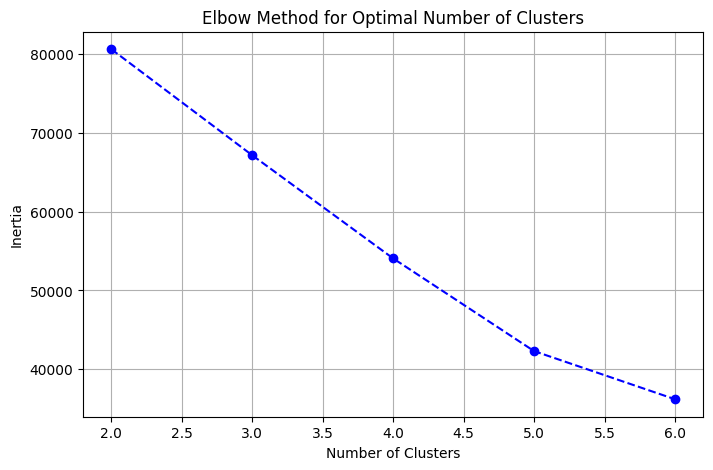

In [96]:
# Plot the elbow method to determine the best cluster count
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [97]:
# Fit the final KMeans model with the selected number of clusters
optimal_k = 5  # Choosen based on the elbow plot
kmeans_final = KMeans(n_clusters=optimal_k, random_state=3101)
kmeans_final.fit(features_balance)
subset_balance['Cluster_Labels'] = kmeans_final.labels_

#Predict cluster labels for the original subset using the same KMeans model
subset_original['Cluster_Labels'] = kmeans_final.predict(features_original)


In [98]:
# List of target variables
target_columns = ['Credit Score','Outstanding Loans', 'Balance']

# Dictionary to hold fitted parameters (mean, std) for each cluster and each target variable
cluster_params = {}

for target in target_columns:
    cluster_params[target] = {}
    # Group by clusters
    for cluster in subset_balance['Cluster_Labels'].unique():
        cluster_data = subset_balance[subset_balance['Cluster_Labels'] == cluster][target]
        # Fit a normal distribution to the data in the cluster
        mean, std = norm.fit(cluster_data)
        cluster_params[target][cluster] = (mean, std)

In [99]:
# Create a function to draw samples based on the cluster label using CLIENTNUM
def generate_synthetic_data_with_clientnum(base_data, cluster_params, target):
    # Initialize a dictionary for storing CLIENTNUM and synthetic values
    synthetic_values = {}
    
    # Iterate over each record in the base data
    for idx, row in base_data.iterrows():
        clientnum = row['CLIENTNUM']  # Fetch the unique identifier
        cluster_label = row['Cluster_Labels']  # Assuming cluster labels are already assigned to base data
        mean, std = cluster_params[target][cluster_label]
        
        # Draw a sample from the normal distribution
        synthetic_value = norm.rvs(loc=mean, scale=std)
        
        # Store the synthetic value with CLIENTNUM as the key
        synthetic_values[clientnum] = synthetic_value
    
    return synthetic_values

# Generate synthetic data for each target variable in the original subset
for target in target_columns:
    synthetic_data = generate_synthetic_data_with_clientnum(subset_original, cluster_params, target)
    
    # Add the synthetic data to the original subset using CLIENTNUM as the identifier
    subset_original[f'Synthetic_{target}'] = subset_original['CLIENTNUM'].map(synthetic_data)

In [100]:
subset_original.columns

Index(['CLIENTNUM', 'Customer_Age', 'Gender', 'Income_Category',
       'No_of_product', 'Gender_Encoded', 'Income_Category_Encoded',
       'Cluster_Labels', 'Synthetic_Credit Score',
       'Synthetic_Outstanding Loans', 'Synthetic_Balance'],
      dtype='object')

In [103]:
# resulting dataframe
features_final = ['CLIENTNUM','Synthetic_Credit Score',
       'Synthetic_Outstanding Loans', 'Synthetic_Balance']

final_df = subset_original.loc[:,features_final]